In [1]:
from pettingzoo.classic import connect_four_v3
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [2]:
env = connect_four_v3.env(render_mode="rgb_array")
env.reset()

# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [3]:
from agents.play_leftmost import PlayLeftmostLegal
from agents.random import RandomPlayer
from agents.malynx_deep import MalynxDeep, MalynxWithoutBlunder
from agents.q_learner import QLearningAgent
from agents.human import HumanPlayer

We import the pre-trained Q-table for Q-learning agent.

In [4]:
import pickle

q_learning_agent = QLearningAgent()
with open("training/agent_q_learner.pkl", 'rb') as f:
    q_learning_agent.q_table = pickle.load(f)

In [5]:
random_agent = RandomPlayer()
leftmost_agent = PlayLeftmostLegal()
malynx_deep_agent = MalynxDeep()
malynx_without_blunder_agent = MalynxWithoutBlunder()
human_agent = HumanPlayer(name= "Human")

# Let's train the QLearner agent!

In [7]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

In [8]:
def train_one_game(agent, opponent, first_player=True):
    eval_env = EnvAgainstPolicy(env, opponent, first_player=first_player)
    done = False
    eval_env.reset()
    obs, _, _, _, _ = eval_env.last()
    while not done:
        # We get the action from the agent
        action = agent.get_action(obs, epsilon=0)
        if action is None:
            # The agent cannot play: draw?
            return 0
        # print(obs['action_mask'],list(np.where(obs['action_mask'] ==1)[0]), action)
        # We move according to the action
        eval_env.step(action)
        next_obs, reward, done, _, _ = eval_env.last()
        # We update the agent's Q-table
        agent.update(obs, action, reward, done, next_obs)

        if done and reward==1:
            # The agent won
            return 1
        elif done and reward==-1:
            # The agent lost
            return -1
        
        obs = next_obs

    # The game ended in a draw
    return 0

def train(agent, opponent, N_episodes=10, N_games=100, first_player=True, alternate_first_player=False):
    # We print the evolution of the agent's statistics, and at the end we plot the evolution of the win rate
    print(f"{'Episode':<10} {'Win':<10} {'Loss':<10} {'Draw':<10}")
    win_rate = []
    for i in range(N_episodes):
        win = 0
        loss = 0
        draw = 0
        for _ in range(N_games):
            result = train_one_game(agent, opponent, first_player=first_player)
            if result == 1:
                win += 1
            elif result == -1:
                loss += 1
            else:
                draw += 1
        print(f"{i:<10} {win:<10} {loss:<10} {draw:<10}")
        win_rate.append(win / N_games)

        if alternate_first_player:
            first_player = not first_player

    plt.plot(win_rate)
    plt.xlabel("Episode")
    plt.ylabel("Win rate")
    plt.title("Evolution of the win rate for {} against {}".format(agent.name, opponent.name))
    plt.show()
    

In [9]:
import pickle

def save_agent(agent, name):
    # Save the agent's Q-table
    # We try to optimize the size of the file by removing the useless entries
    q_table = {}
    for key, value in agent.q_table.items():
        if value != 0:
            q_table[key] = value
    
    with open(name, 'wb') as f:
        pickle.dump(q_table, f)

def load_agent(name):
    # Load the agent's Q-table
    agent = QLearningAgent()
    with open(name, 'rb') as f:
        agent.q_table = pickle.load(f)
    return agent

In [10]:
def train_against_opponent(opponent):
    print("Training against {}".format(opponent.name))
    train(q_learning_agent, opponent, N_episodes=100, N_games=100, first_player=True)
    train(q_learning_agent, opponent, N_episodes=250, N_games=100, first_player=False)
    train(q_learning_agent, q_learning_agent, N_episodes=100, N_games=100, first_player=False)
    train(q_learning_agent, opponent, N_episodes=100, N_games=100, first_player=True)

Training against Random Player
Episode    Win        Loss       Draw      
0          84         16         0         
1          91         9          0         
2          92         8          0         
3          89         10         1         
4          88         12         0         
5          83         17         0         
6          82         16         2         
7          86         14         0         
8          89         11         0         
9          85         15         0         
10         79         21         0         
11         86         14         0         
12         78         22         0         
13         82         17         1         
14         88         11         1         
15         87         13         0         
16         85         15         0         
17         84         16         0         
18         87         13         0         
19         91         9          0         
20         83         17         0         
2

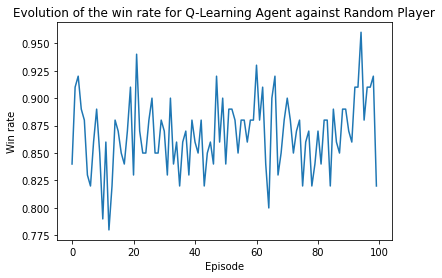

Episode    Win        Loss       Draw      
0          80         20         0         
1          78         22         0         
2          77         23         0         
3          80         20         0         
4          79         21         0         
5          91         9          0         
6          77         23         0         
7          84         16         0         
8          78         22         0         
9          77         23         0         
10         80         20         0         
11         79         20         1         
12         86         14         0         
13         84         16         0         
14         76         24         0         
15         78         22         0         
16         76         24         0         
17         85         15         0         
18         73         27         0         
19         75         24         1         
20         77         23         0         
21         82         17        

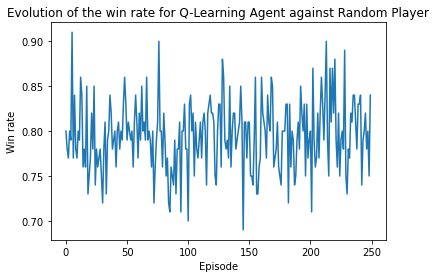

Episode    Win        Loss       Draw      
0          92         8          0         
1          91         9          0         
2          90         10         0         
3          91         9          0         
4          90         10         0         
5          90         10         0         
6          92         8          0         
7          95         5          0         
8          93         7          0         
9          92         8          0         
10         90         10         0         
11         90         10         0         
12         91         9          0         
13         95         5          0         
14         95         5          0         
15         91         9          0         
16         89         11         0         
17         94         6          0         
18         94         6          0         
19         90         10         0         
20         92         8          0         
21         90         10        

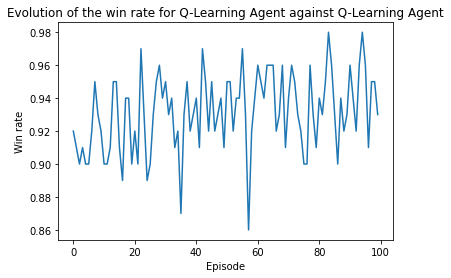

Episode    Win        Loss       Draw      
0          83         17         0         
1          88         12         0         
2          91         9          0         
3          89         11         0         
4          87         13         0         
5          93         7          0         
6          88         12         0         
7          89         10         1         
8          88         12         0         
9          92         8          0         
10         82         18         0         
11         88         12         0         
12         84         16         0         
13         86         14         0         
14         88         12         0         
15         84         16         0         
16         81         19         0         
17         90         10         0         
18         88         12         0         
19         88         12         0         
20         87         13         0         
21         88         12        

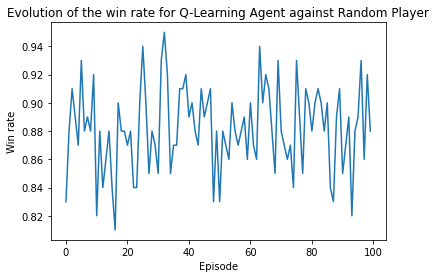

In [11]:
train_against_opponent(random_agent)

In [12]:
train_against_opponent(malynx_deep_agent)

Training against Malynx Deep
Episode    Win        Loss       Draw      
0          0          100        0         
1          0          100        0         
2          0          100        0         
3          0          100        0         
4          0          100        0         
5          0          100        0         
6          0          100        0         
7          0          100        0         
8          0          100        0         
9          0          100        0         
10         0          100        0         
11         0          100        0         
12         0          100        0         
13         0          100        0         
14         0          100        0         
15         0          100        0         
16         0          100        0         
17         0          100        0         
18         0          100        0         
19         0          100        0         
20         0          100        0         
21 

KeyboardInterrupt: 

# Let's save our agent

In [ ]:
save_agent(q_learning_agent, "training/agent_q_learner_1.pkl")